# HW01: Multivariate Parametric Classification
## Hamza Dehidi KU 0077989
### October 18, 2021

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import math
import copy

## Parameters

In [2]:
np.random.seed(521)
# The below Parameters are givien.
# Mean parameters
class_means = np.array([[+0.0, +2.5],
                        [-2.5, -2.0],
                        [+2.5, -2.0]])
# Covariance parameters
class_covariances = np.array([[[+3.2, +0.0],
                               [+0.0, +1.2]],
                              [[+1.2, +0.8],
                               [+0.8, +1.2]],
                              [[+1.2, -0.8],
                               [-0.8, +1.2]]])
# Sample sizes
class_sizes = np.array([120, 80, 100])

## Data Generation

In [3]:
# Generate random samples
points1 = np.random.multivariate_normal(class_means[0,:], class_covariances[0,:,:], class_sizes[0])
points2 = np.random.multivariate_normal(class_means[1,:], class_covariances[1,:,:], class_sizes[1])
points3 = np.random.multivariate_normal(class_means[2,:], class_covariances[2,:,:], class_sizes[2])
X = np.concatenate((points1, points2, points3))

# Labeling the data 
y_truth = np.concatenate((np.repeat(1, class_sizes[0]), np.repeat(2, class_sizes[1]), np.repeat(3, class_sizes[2])))

## Plotting Data

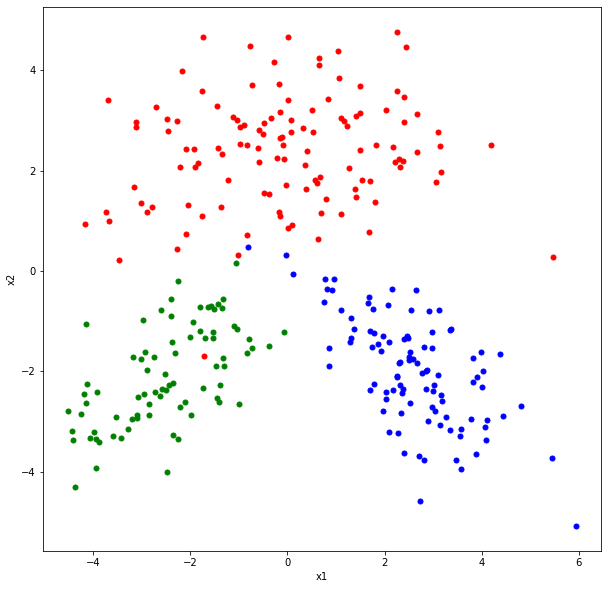

In [4]:
# Assuming we have no idea about the parameters exploring the data by ploting. 
# plot generated data points 
plt.figure(figsize = (10, 10))
plt.plot(points1[:,0], points1[:,1], "r.", markersize = 10) #first dataset
plt.plot(points2[:,0], points2[:,1], "g.", markersize = 10) #Second dataset
plt.plot(points3[:,0], points3[:,1], "b.", markersize = 10) #Third dataset
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Getting Data Size, Sample numbers & Dimentions

In [5]:
# Getting number of classes(K), number of samples(N) & number of dimentions (D)
K = np.max(y_truth)
N = X.shape[0]
D = X.shape[1]

## Parameter Estimation

In [6]:
K

3

### Calculate sample means

$\widehat{\mu_{c}} = \dfrac{\sum\limits_{i = 1}^{N} x_{i} \mathbb{1}(y_{i} = c)}{\sum\limits_{i = 1}^{N} \mathbb{1}(y_{i} = c)}$

In [7]:
# Calculate sample means for each dataset along each dimention

sample_means = np.reshape([np.mean((X[y_truth == (c + 1)]),axis=0)
                           for c in range(K)],(K,D))  
                    

In [8]:
print(sample_means)

[[-0.06002766  2.37891762]
 [-2.4831697  -2.07440706]
 [ 2.56694496 -1.97561106]]


### Calculate sample variances

$\widehat{\sigma_{c}^{2}} = \dfrac{\sum\limits_{i = 1}^{N} (x_{i} - \widehat{\mu_{c}})^{T} \mathbb{1}(y_{i} = c)(x_{i} - \widehat{\mu_{c}})^{T}} {\sum\limits_{i = 1}^{N} \mathbb{1}(y_{i} = c)}$

In [9]:
# Calculate sample variance & covariances for each dataset
# I could not solve it by vector multiplication as the above equation
# x[y == (c + 1)][:,i] getting the the x values each class for each dimention.
# sample_means[c][i] for each class for each dimention
# nested loops total 12 loop, 4 for each dimention
# first loop when i&j = 0, calculates the variance of the first dimention.
# second and third loops calculate the covariances.
# forth loop calculates the variance of the second dimention.

sample_covariances = np.reshape([(np.mean((X[y_truth == (c + 1)][:,i] - sample_means[c][i])
                              *(X[y_truth == (c + 1)][:,j] - sample_means[c][j])))
                     for c in range(K) 
                     for i in range (D) 
                     for j in range (D)],(K,D,D))

In [10]:
print(sample_covariances)

[[[ 3.50095118  0.31087727]
  [ 0.31087727  1.21501353]]

 [[ 1.19789275  0.64059317]
  [ 0.64059317  0.95264859]]

 [[ 1.25199541 -0.79696981]
  [-0.79696981  1.17191479]]]


### Calculate prior probabilities

$\widehat{P}(y_{i} = c) = \dfrac{\sum\limits_{i = 1}^{N} \mathbb{1}(y_{i} = c)}{N}$

In [11]:
# calculate prior probabilities
class_priors = [np.mean(y_truth == (c + 1)) for c in range(K)]

In [12]:
print(class_priors)

[0.4, 0.26666666666666666, 0.3333333333333333]


## Parametric Classification

\begin{align*}
g_{c}(x) &= \log p(x | y = c) + \log P(y = c)\\
&= -\dfrac{d}{2} \log(2 \pi) -\dfrac{1}{2}\log(|\Sigma_{c}|)-\dfrac{1}{2}(x - \mu_{c})^{T}\Sigma_{c}^{-1}(x - \mu_{c}) + \log P(y = c)\\
&= x^{T}W_{c}x + w_{c}^{T}x + w_{c 0}\\
W_{c} &= -\dfrac{1}{2}\Sigma_{c}^{-1} \\
w_{c} &= \Sigma_{c}^{-1}\mu_{c} \\
w_{c 0} &= -\dfrac{1}{2}\mu_{c}^{T}\Sigma_{c}^{-1}\mu_{c} -\dfrac{d}{2} \log(2 \pi) - \dfrac{1}{2}\log(|\Sigma_{c}|) + \log P(y = c)
\end{align*}


## Creating score function


In [13]:
#I'm using the first method not the Ws.
# for i in range(x.shape[0]) produces 300 itirations,  for c in range(K) gives 3 itirations.
# total 900 itirations, 3 scors for each dataset.

def score_func(X):
    total_scores = np.zeros((X.shape[0], 0))
    for c in range(K):
        scores = np.vstack([- 0.5 * D * np.log(2 * math.pi) - 0.5 * np.log(np.linalg.det(sample_covariances[c]))
                         - 0.5 * (X[j] - sample_means[c]).T @ np.linalg.inv(sample_covariances[c]) @ (X[j] - sample_means[c]) 
                         + np.log(class_priors[c]) for j in range(X.shape[0])])
        total_scores = np.hstack((total_scores,scores))
        
    return total_scores


In [14]:
# This loop will assign the highest score for observation.
scores = score_func(X)
y_predicted = np.zeros((N)).astype(int)

for r in range(N):
    if scores[r,0] == np.max(scores[r,:]):
        y_predicted[r] = 1
    elif scores[r,1] == np.max(scores[r,:]):
        y_predicted[r] = 2
    elif scores[r,2] == np.max(scores[r,:]):        
        y_predicted[r] = 3


In [15]:
# calculate confusion matrix
confusion_matrix = pd.crosstab(y_predicted, y_truth, rownames = ['y_pred'], colnames = ['y_truth'])
print(confusion_matrix)

y_truth    1   2   3
y_pred              
1        119   1   2
2          1  79   0
3          0   0  98


## Visualization

In [16]:
# Creating a grid 
# np.ravel(x1_grid) to break the array
# np.array([[xx,yy] for xx,yy in zip to assign every two entries togather
# np.argmax(score_func(coordinations),axis =1 to choose the highest score for each tuple
# reshape(x1_grid.shape) to reshape and fit x1_grid,x2_grid sizes


x1_interval = np.linspace(-6, +6, 200)
x2_interval = np.linspace(-6, +6, 200)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
coordinations = np.array([[xx,yy] for xx,yy in zip(np.ravel(x1_grid),np.ravel(x2_grid))])
z = np.argmax(score_func(coordinations),axis =1).reshape(x1_grid.shape)


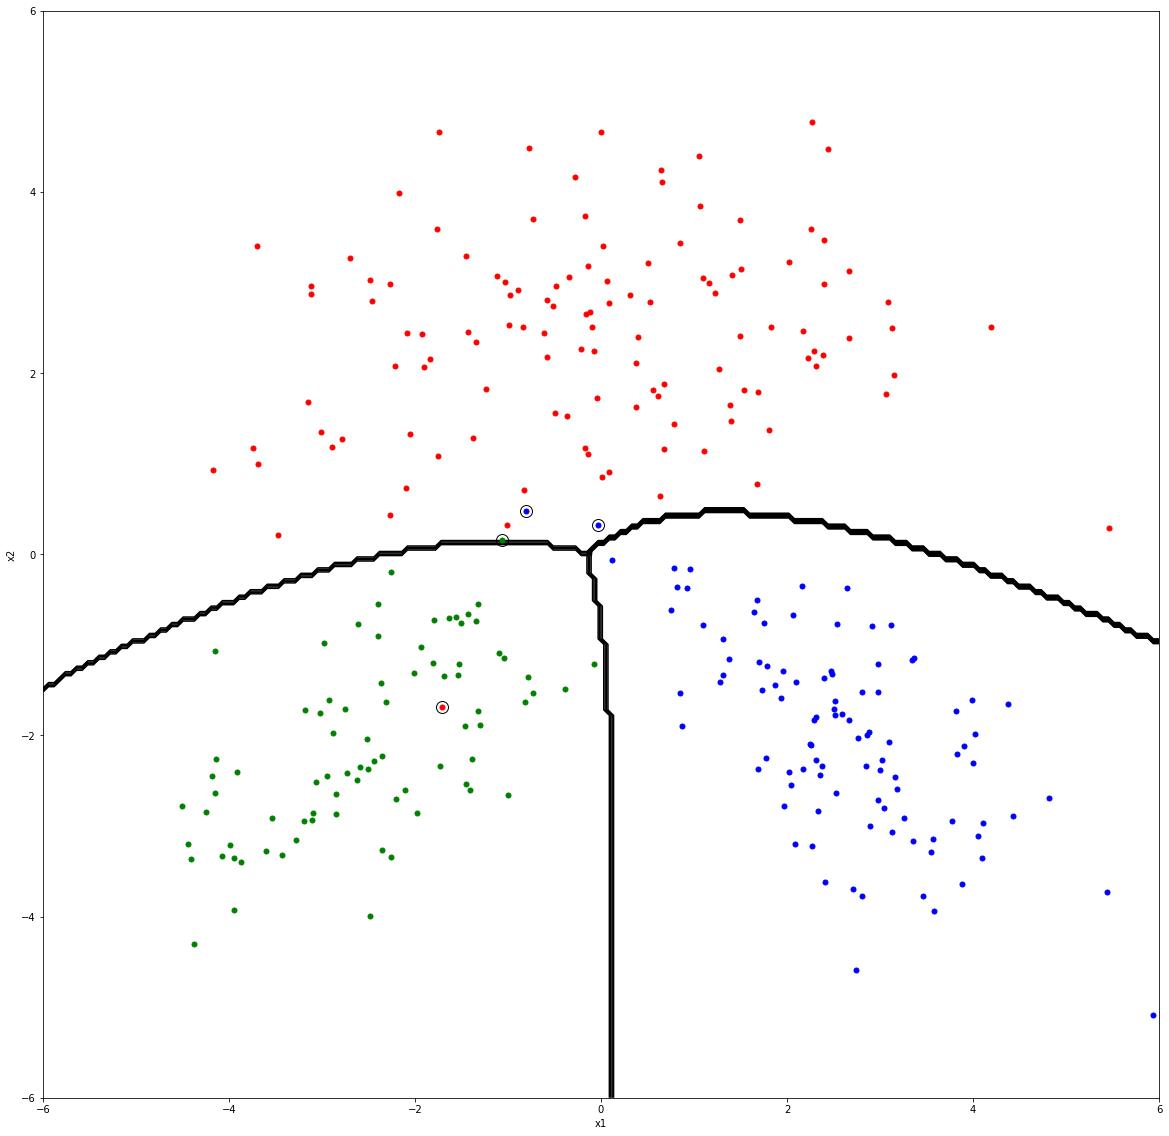

In [22]:
plt.figure(figsize = (20, 20))
plt.plot(points1[:,0], points1[:,1], "r.", markersize = 10)
plt.plot(points2[:,0], points2[:,1], "g.", markersize = 10)
plt.plot(points3[:,0], points3[:,1], "b.", markersize = 10)
plt.plot(X[y_predicted != y_truth, 0], X[y_predicted != y_truth, 1], "ko", markersize = 12, fillstyle = "none")
plt.contour(x1_grid, x2_grid, z ,  colors = "k")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()